# Chapter 3 word2vec

## 3.1 추론 기반 기법과 신경망

### 3.1.1 통계 기반 기법의 문제점

- 대규모 말뭉치를 다룰 때 문제 발생, 어휘가 100만 개라면, 100만 X 100만의 행렬을 만들어야 한다.
- SVD를 적용할 때도 $O(n^3)$의 시간이 들어 비효율적이다.\

하지만 추론 기반에서는 신경망을 기반으로 미니배치로 여러 번 학습시켜 가중치를 갱신할 수 있다. 큰 작업을 처리하기 어려운 경우 나눠서 처리할 수 있다. 여러 머신과 GPU를 활용하면 속도는 더욱 빨라진다.

### 3.1.2 추론 기반 기법 개요

주변 단어(맥락)이 주어졌을 때 어떤 단어가 들어갈지 추론하는 방식이다. 이 작업을 반복하면서 단어의 출현 패턴을 학습한다.

<img src="./images/fig%203-3.png" width=500>

- 모델: 신경망
- 학습 목표: 말뭉치를 통한 올바른 추측
- 학습 결과: 단어의 분산 표현

통계 기반 기법처럼 분포 가설에 기초한다. 단어의 동시발생 가능성을 얼마나 잘 모델링하는지가 중요하다.

### 3.1.3 신경망에서의 단어 처리

대표적으로 단어를 **원핫 벡터**로 변환해서 사용한다.

단어를 원핫 벡터로 표현하는 방법:  
총 어휘 수만큼의 원소를 갖는 벡터를 준비하고, 인덱스와 같은 단어 ID의 원소를 1, 나머지는 0으로 한다. 고정 길이이기 때문에 신경망의 입력층에서 뉴런의 수를 고정할 수 있다.

<img src="./images/fig%203-7.png" width=600>

여기서는 편향을 생략

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)

[[-0.33058015 -1.56249589 -0.36852109]]


원핫 벡터로 표현되어 있기 때문에 가중치로부터 행벡터를 뽑아내는 것으로 볼 수 있다.

In [2]:
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.46016462  0.4332086  -1.10626672]]


## 3.2 단순한 word2vec

#### word2vec
- CBOW(continuous bag-of-words) 모델
- skip-gram

### 3.2.1 CBOW 모델의 추론 처리

- 타깃: 중앙 단어
- 맥락: 주변 단어
- 맥락으로부터 타깃을 추측하는 신경망
- 신경망의 입력: 맥락

<img src="./images/fig%203-9.png" width=600>

- 입력층: 2개
    - 맥락으로 고려할 단어 수로 입력층의 수가 정해진다.
- $W_{in}$: 은닉층으로 변환시키는 가중치, 모든 입력층에 똑같이 적용
    - 각 행에 해당 단어의 분산 표현이 담겨 있다.
    - 학습을 진행할수록 단어를 잘 추측하는 방향으로 표현이 갱신됨
- $W_{out}$: 출력층으로 변환시키는 가중치
- 은닉층의 뉴런은 변환된 값들의 평균
- 출력층은 각 단어별 점수이고 소프트맥스 함수로 확률을 얻을 수 있다.
- 은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 하는 것이 중요하다. 
    - 단어 예측에 필요한 정보를 간결하게 담게 되며, 밀집벡터 표현을 얻을 수 있기 때문이다.
    - 인코딩: 입력 -> 은닉(인간 이해 X)
    - 디코딩: 은닉 -> 출력(인간 이해할 수 있도록 복원)
    
<img src="./images/fig%203-11.png" width=600>

In [3]:
# CBOW 모델의 추론 과정
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)    # 두 맥락은 동일한 W_in을 공유한다
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-1.74801686  0.27589949  0.26169741 -1.49295695 -1.2378314  -1.53780328
  -4.46044015]]


주의할 점: 입력층이 여러 개 있고, 가중치를 공유한다.

### 3.2.2 CBOW 모델의 학습

<img src="./images/fig%203-14.png" width=700>

- 다중 클래스 분류라 softmax 함수를 사용해서 점수를 확률로 반환하고 교차 엔트로피 오차로 손실을 계산한다.

### 3.2.3 word2vec의 가중치와 분산 표현

가중치에는 단어의 분산 표현이 저장돼있다.
- 입력 측 가중치: 행이 각 단어의 분산 표현에 해당
- 출력 측 가중치: 열이 각 단어의 분산 표현에 해당

최종적으로 입력 측 가중치를 단어의 분산 표현으로 선택하는 것이 대중적이다.

## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃

- 맥락: 주변 단어, 여러 개가 될 수 있다.
- 타깃: 목표로 하는 단어, 단 1개
- 맥락을 통해 타깃이 나올 확률을 높이는 방향으로 학습

In [5]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
# corpus를 주면 맥락과 타깃으로 나눠주는 함수
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [7]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환

In [8]:
# 단어 ID를 원핫 표현으로 변환하는 함수 구현
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [9]:
print(target)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [10]:
print(target.shape)
print(contexts.shape)

(6, 7)
(6, 2, 7)


## 3.4 CBOW 모델 구현

In [1]:
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer(score, target)
        
        return loss
    
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        
        return None

<img src="./images/fig%203-20.png" width=700>

### 3.4.1 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 362 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 363 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 364 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 365 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 366 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 367 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 368 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 369 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 370 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 371 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 372 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 373 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 374 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 375 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 376 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 377 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 378 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 379 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 380 |  반복 1 / 2 | 시간 0[s] | 손실 0.95
| 에폭 381 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 382 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 383 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 384 |  반복 1 / 2 | 시간 0[s] | 손실 0.92
| 에폭 385 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 386 |  반복 1

| 에폭 567 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 568 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 569 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 570 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 571 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 572 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 573 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 574 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 575 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 576 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 577 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 578 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 579 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 580 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 581 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 582 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 583 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 584 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 585 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 586 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 587 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 588 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 589 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 590 |  반복 1 / 2 | 시간 0[s] | 손실 0.66
| 에폭 591 |  반복 1

| 에폭 938 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 939 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 940 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 941 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 942 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 943 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 944 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 945 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 946 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 947 |  반복 1 / 2 | 시간 0[s] | 손실 0.34
| 에폭 948 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 949 |  반복 1 / 2 | 시간 0[s] | 손실 0.41
| 에폭 950 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 951 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 952 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 953 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 954 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 955 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 956 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 957 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 958 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 959 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 960 |  반복 1 / 2 | 시간 0[s] | 손실 0.34
| 에폭 961 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 962 |  반복 1

C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\KJK\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49892 missing from current font.
  f

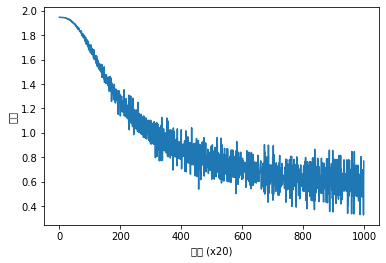

In [5]:
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [6]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.2413106 -1.0964949  1.0820054 -1.1484023 -1.1857373]
say [-0.33654106  1.2083046  -1.218706    1.2281688   1.2207886 ]
goodbye [ 0.80608153 -0.7664269   0.8416254  -0.7115481  -0.6980996 ]
and [-1.9172773   0.9917167  -0.9308394   0.93270993  0.99845034]
i [ 0.80110484 -0.7266062   0.82103735 -0.6890192  -0.68328774]
hello [ 1.2386434 -1.1122558  1.0848594 -1.1790915 -1.1720238]
. [ 1.8007114  1.1263746 -1.1385503  1.1443175  1.1097484]


## 3.5 word2vec 보충

### 3.5.1 CBOW 모델과 확률

#### 확률 표기법
- $P(A)$: A가 일어날 확률
- $P(A, B)$: 동시 확률
- $P(A|B)$: 사후 확률, B라는 사건이 주어졌을 때 A가 일어날 확률

#### CBOW의 확률 표현(윈도우 크기가 1인 경우)

$$P(w_t|w_{t-1},w_{t+1})$$

- 손실 함수(단일)
    - 음의 로그 가능도(negative log likelihood)

$$L = -logP(w_t|w_{t-1}, w_{t+1})$$


- 손실 함수(말뭉치 전체)

$$L = - \frac 1 T \sum^T_{t=1} logP(w_t|w_{t-1}, w_{t+1})$$

### 3.5.2 skip-gram 모델

CBOW 모델의 맥락과 타깃을 역전시킨 모델이다.

<img src="./images/fig%203-23.png" width=600>

skip-gram은 중앙 단어로부터 주변 단어를 추측한다. 따라서 skip-gram의 입력층은 하나이고, 출력층은 맥락의 수만큼 존재한다. 각 출력층의 손실을 구한 후 개별 손실을 모두 더한 값을 최종 손실로 한다.

$$P(w_{t-1}, w_{t+1}|w_t)$$

위 수식을 맥락의 단어들 사이에 관련성이 없다고 가정(조건부 독립)하고 다음과 같이 분해한다.

$$P(w_{t-1}, w_{t+1}|w_t) = P(w_{t-1}|w_t)P(w_{t+1}|w_t)$$

교차 엔트로피 오차에 적용한 손실함수

$$\begin{align}
L & = -logP(w_{t-1},w_{t+1}|w_t) \\
& = -logP(w_{t-1}|w_t)P(w_{t+1}|w_t) \\
& = -(logP(w_{t-1}|w_t)+logP(w_{t+1}|w_t)) \\
\end{align}$$

말뭉치 전체에 대한 손실함수

$$L = -\frac 1 T \sum^T_{t=1}(logP(w_{t-1}|w_t)+logP(w_{t+1}|w_t))$$

#### CBOW vs skip-gram?

skip-gram의 정밀도가 높은 경우가 많다.말뭉치가 커질수록 저빈도 단어나 유추 문제의 성능에서 skip-gram이 더욱 좋다. 속도는 CBOW가 더 빠르다. 손실을 계산하는 비용이 skip-gram이 더욱 크기 때문이다.

### 3.5.2 통계 기반 vs 추론 기반

1. 통계 기반은 1회 학습하여 분산 표현을 얻은 반면 추론 기반은 미니배치로 여러번 학습한다.
2. 새로운 단어가 생기면 통계 기반은 처음부터 다시 계산해야 한다. 추론 기반은 현재 얻은 분산 표현을 해치지 않으면서 매개 변수를 다시 학습할 수 있다.
3. 통계 기반은 단순히 단어의 유사성이 인코딩된다. 추론 기반은 유사성 뿐만 아니라, 단어 사이의 패턴까지 파악되어 인코딩된다.
    - word2vec은 king - man + woman = queen을 풀 수 있다.
4. 유사성 관련 정확도는 둘 다 비슷하다.
5. 두 기법은 서로 관련있다.
    - 네거티브 샘플링을 이용한 모델
    - 둘을 합친 GloVe 기법도 존재